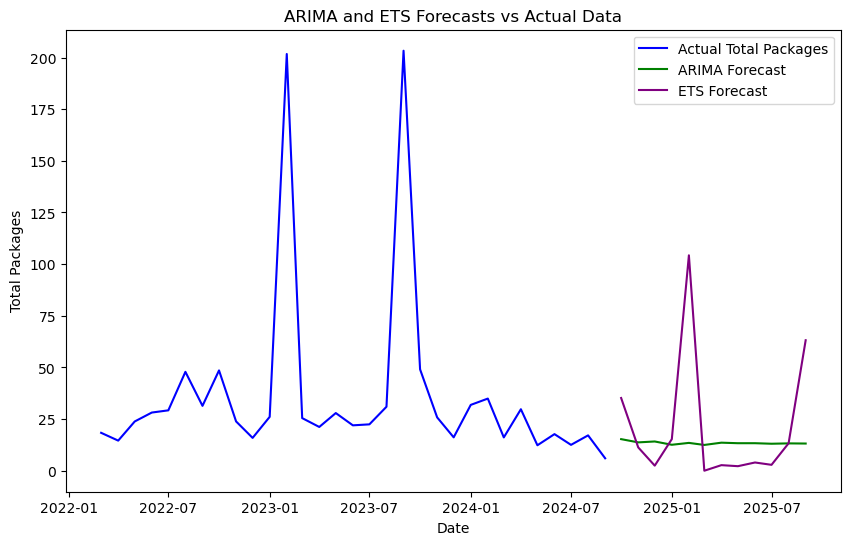

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt

# Load the data 
utl_data = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")

# Convert the 'Process TimestampDateOnly' column to datetime format
utl_data['Process TimestampDateOnly'] = pd.to_datetime(utl_data['Process TimestampDateOnly'])

# Removing specific problematic data point
utl_data = utl_data[utl_data['Process TimestampDateOnly'] != '1899-12-30']

# Filter the data to include only rows with dates on or after January 1, 2022
utl_data = utl_data[utl_data['Process TimestampDateOnly'] >= '2022-01-01']

# Calculate monthly means for each year
utl_data['month'] = utl_data['Process TimestampDateOnly'].dt.to_period('M').dt.to_timestamp()
utl_mean = utl_data.groupby('month')['Count of P_id'].mean().reset_index()

# Rename 'Count of P_id' to 'Total packages'
utl_mean = utl_mean.rename(columns={'Count of P_id': 'Total packages'})

# Fitting ARIMA and ETS models

# ARIMA model
arima_model = sm.tsa.ARIMA(utl_mean['Total packages'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# ETS model (Exponential Smoothing)
ets_model = ExponentialSmoothing(utl_mean['Total packages'], seasonal_periods=12, trend='add', seasonal='add')
ets_fit = ets_model.fit()

# Forecast for the next 12 months using both models
forecast_horizon = 12

# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=forecast_horizon)
arima_forecast_mean = arima_forecast.predicted_mean

# Forecast with ETS
ets_forecast = ets_fit.forecast(steps=forecast_horizon)

# Forecast dates
forecast_dates = [utl_mean['month'].iloc[-1] + MonthEnd(i) for i in range(1, forecast_horizon + 1)]

# Create a DataFrame for the forecast
forecast_data = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA_Forecast': arima_forecast_mean,
    'ETS_Forecast': ets_forecast
})

# Plot actual data and forecasts using Matplotlib
plt.figure(figsize=(10, 6))

# Plot actual total packages
plt.plot(utl_mean['month'], utl_mean['Total packages'], label='Actual Total Packages', color='blue')

# Plot ARIMA forecast
plt.plot(forecast_data['Date'], forecast_data['ARIMA_Forecast'], label='ARIMA Forecast', color='green')

# Plot ETS forecast
plt.plot(forecast_data['Date'], forecast_data['ETS_Forecast'], label='ETS Forecast', color='purple')

# Formatting the plot
plt.title('ARIMA and ETS Forecasts vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Total Packages')
plt.legend()

# Show the plot
plt.show()


 1. Load, Convert Dates & Set Index

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")
data['Date'] = pd.to_datetime(data['Date'])         # Convert to datetime
data.set_index('Date', inplace=True)                # Set date as index
data = data.asfreq('D')                             # Force daily frequency (introduces NaNs)
data['Total_Shipments'].interpolate(inplace=True)   # Fill gaps


C:\Users\hp\AppData\Local\Temp\ipykernel_2056\2250528368.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





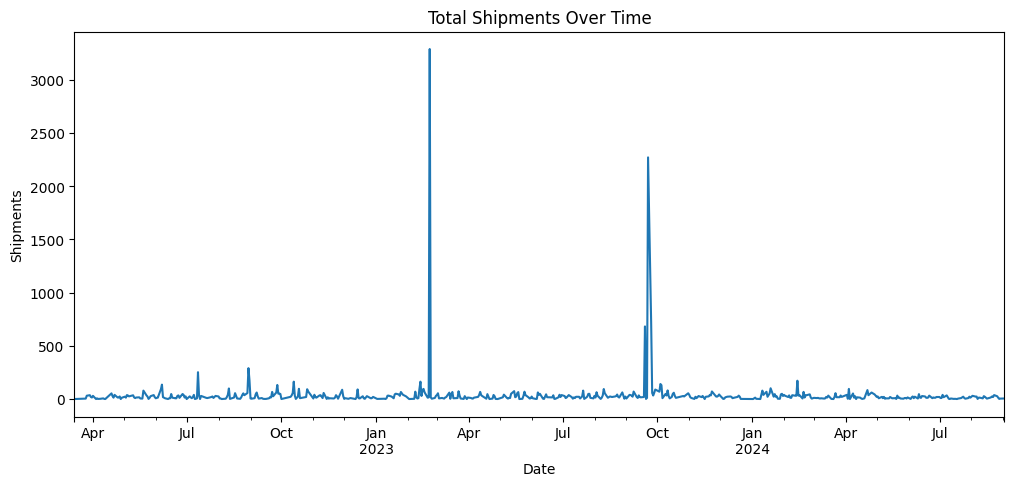

In [25]:
data['Total_Shipments'].plot(figsize=(12, 5), title='Total Shipments Over Time')
plt.ylabel('Shipments')
plt.show()


In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Total_Shipments'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -13.212918463730244
p-value: 1.0382631284446262e-24


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11594.994, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11726.059, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11606.840, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11631.690, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11593.451, Time=0.60 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=11616.561, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11593.684, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11595.427, Time=0.84 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11600.874, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11592.986, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11598.937, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11595.983, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11593.980, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11596.662, Time=1.12 sec
 ARIMA(2,0,1)(0,0,0

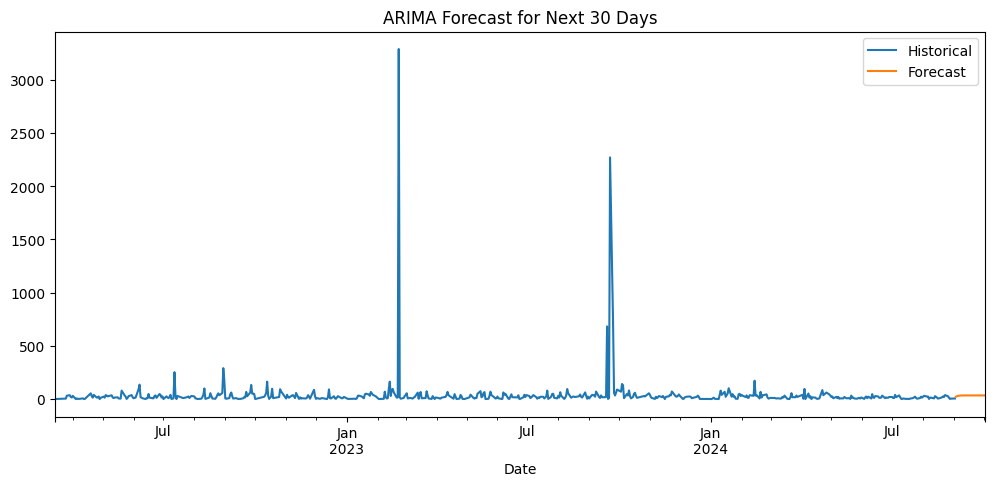

In [27]:
!pip install pmdarima
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Auto fit ARIMA
model = auto_arima(data['Total_Shipments'], seasonal=False, trace=True)

# Forecast next 30 days
n_periods = 30
forecast = model.predict(n_periods=n_periods)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Plot
plt.figure(figsize=(12,5))
data['Total_Shipments'].plot(label='Historical')
pd.Series(forecast, index=forecast_index).plot(label='Forecast')
plt.title("ARIMA Forecast for Next 30 Days")
plt.legend()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_2056\2531660510.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11594.994, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11726.059, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11606.840, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11631.690, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11593.451, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=11616.561, Time=0.71 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11593.684, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11595.427, Time=0.74 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11600.874, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11592.986, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11598.937, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11595.983, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11593.980, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11596.662, Time=1.23 sec
 ARIMA(2,0,1)(0,0,0

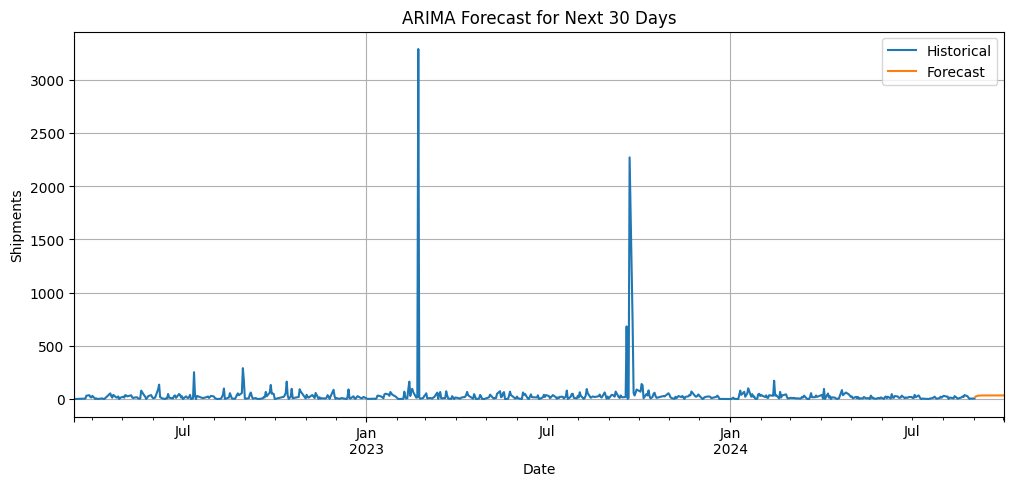

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Step 1: Load and preprocess
data = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # daily frequency
data.columns = data.columns.str.strip().str.replace(" ", "_")
data['Total_Shipments'].interpolate(inplace=True)

# Step 2: Fit ARIMA model
model = auto_arima(data['Total_Shipments'], seasonal=False, trace=True, suppress_warnings=True)

# Step 3: Forecast next 30 days
n_periods = 30
forecast = model.predict(n_periods=n_periods)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_periods)
forecast_series = pd.Series(forecast, index=forecast_index)

# Step 4: Plot
plt.figure(figsize=(12,5))
data['Total_Shipments'].plot(label='Historical')
forecast_series.plot(label='Forecast')
plt.title("ARIMA Forecast for Next 30 Days")
plt.ylabel("Shipments")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted_Shipments': forecast})
forecast_df.to_csv("forecast_output.csv", index=False)


C:\Users\hp\AppData\Local\Temp\ipykernel_2056\611688460.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



02:38:35 - cmdstanpy - INFO - Chain [1] start processing
02:38:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the r

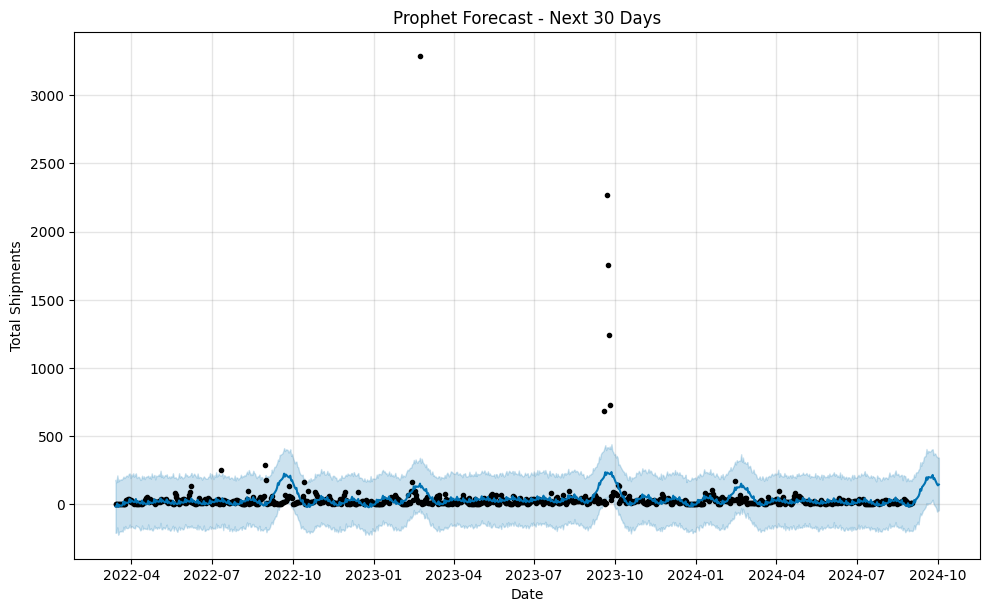

In [33]:
pip install prophet
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load & clean data
data = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.columns = data.columns.str.strip().str.replace(" ", "_")  # Clean column names
data = data.set_index('Date').asfreq('D')
data['Total_Shipments'].interpolate(inplace=True)

# Prophet needs 2 columns: 'ds' (date) and 'y' (value)
df_prophet = data.reset_index()[['Date', 'Total_Shipments']]
df_prophet.columns = ['ds', 'y']

# Create and fit the model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=30)  # Forecast 30 days into the future

# Predict
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Total Shipments")
plt.grid(True)
plt.show()


C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



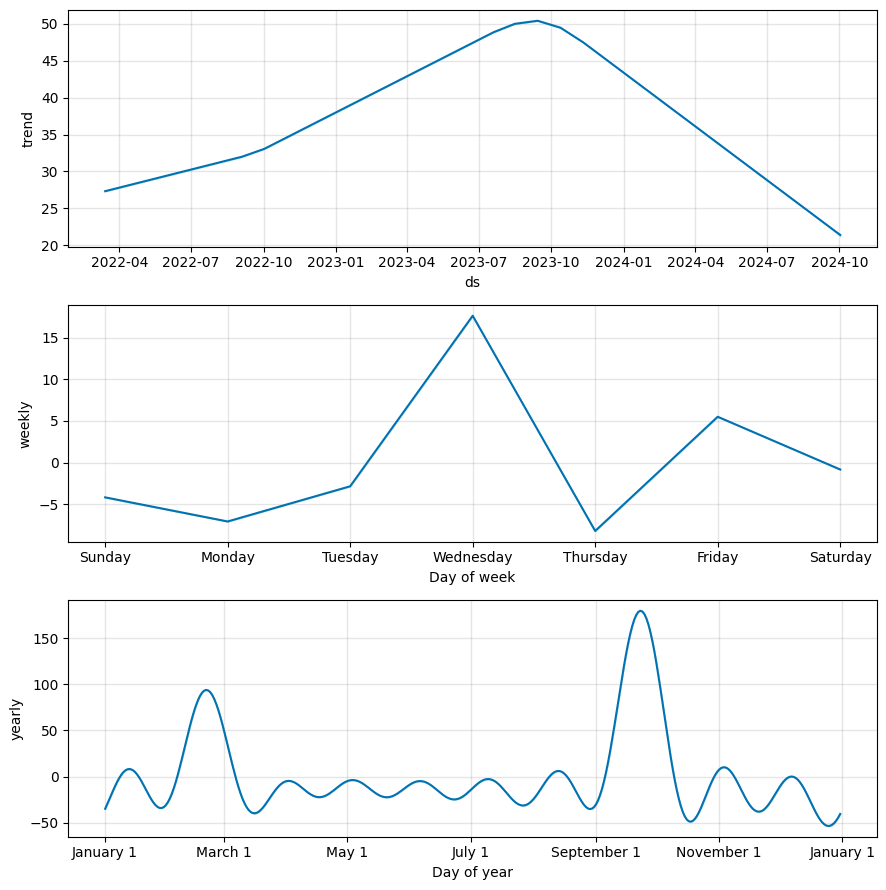

In [34]:
model.plot_components(forecast)
plt.show()


In [35]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("prophet_forecast.csv", index=False)


02:41:42 - cmdstanpy - INFO - Chain [1] start processing
02:41:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



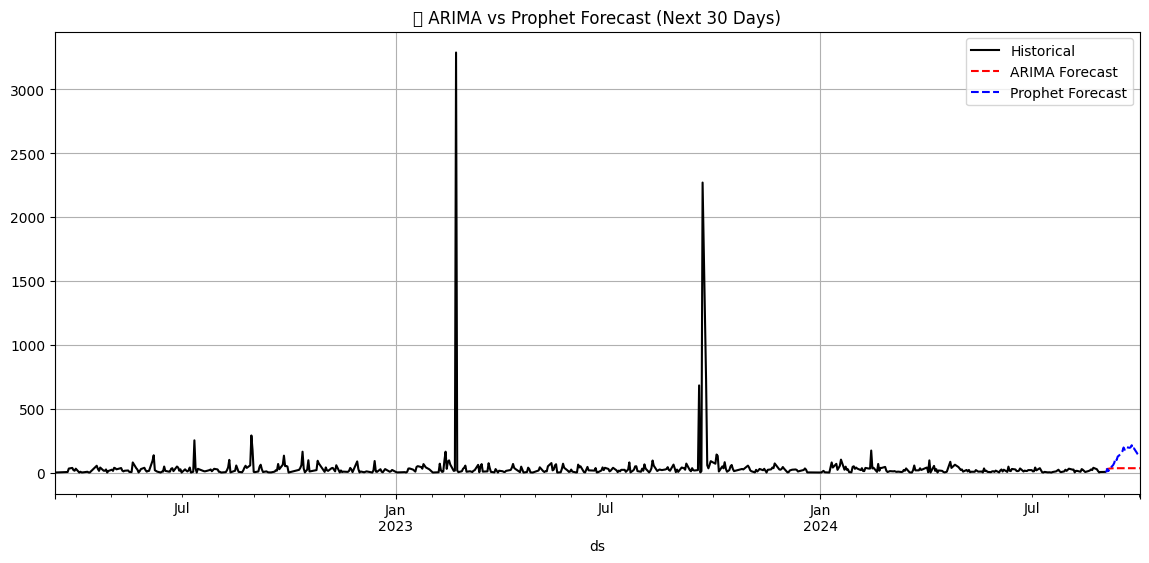

In [36]:
# ARIMA Forecast
from pmdarima import auto_arima

# Prepare ARIMA again (if not done already)
arima_model = auto_arima(data['Total_Shipments'], seasonal=False, trace=False, suppress_warnings=True)
arima_forecast = arima_model.predict(n_periods=30)
arima_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)

# Prophet Forecast (if not already done)
from prophet import Prophet

df_prophet = data.reset_index()[['Date', 'Total_Shipments']]
df_prophet.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

# Extract Prophet forecast
prophet_future = prophet_forecast[['ds', 'yhat']].set_index('ds')[-30:]

# Plot both forecasts
plt.figure(figsize=(14,6))
data['Total_Shipments'].plot(label='Historical', color='black')
pd.Series(arima_forecast, index=arima_index).plot(label='ARIMA Forecast', linestyle='--', color='red')
prophet_future['yhat'].plot(label='Prophet Forecast', linestyle='--', color='blue')
plt.title("📈 ARIMA vs Prophet Forecast (Next 30 Days)")
plt.legend()
plt.grid(True)
plt.show()


02:42:50 - cmdstanpy - INFO - Chain [1] start processing
02:42:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



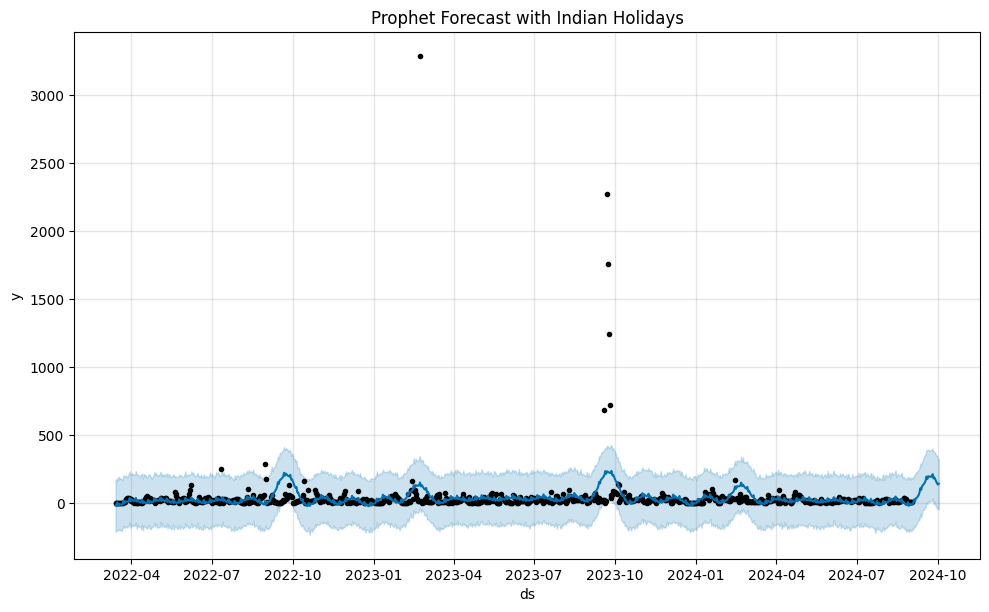

In [37]:
# Create a holiday DataFrame
indian_holidays = pd.DataFrame({
    'holiday': 'indian_festival',
    'ds': pd.to_datetime([
        '2024-01-26',  # Republic Day
        '2024-03-25',  # Holi
        '2024-08-15',  # Independence Day
        '2024-11-01',  # Diwali (approx date)
        '2024-12-25'   # Christmas
    ]),
    'lower_window': 0,
    'upper_window': 1  # Effect can last 1 day after
})

# Initialize Prophet with holidays
model_with_holidays = Prophet(holidays=indian_holidays)
model_with_holidays.fit(df_prophet)

# Future and forecast
future_holiday = model_with_holidays.make_future_dataframe(periods=30)
forecast_holiday = model_with_holidays.predict(future_holiday)

# Plot
model_with_holidays.plot(forecast_holiday)
plt.title("Prophet Forecast with Indian Holidays")
plt.grid(True)
plt.show()


In [38]:
combined_forecast = pd.DataFrame({
    'Date': arima_index,
    'ARIMA': arima_forecast,
    'Prophet': prophet_future['yhat'].values
})
combined_forecast.to_csv("forecast_comparison.csv", index=False)


C:\Users\hp\AppData\Local\Temp\ipykernel_2056\3165873846.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



02:47:06 - cmdstanpy - INFO - Chain [1] start processing
02:47:06 - cmdstanpy - INFO - Chain [1] done processing


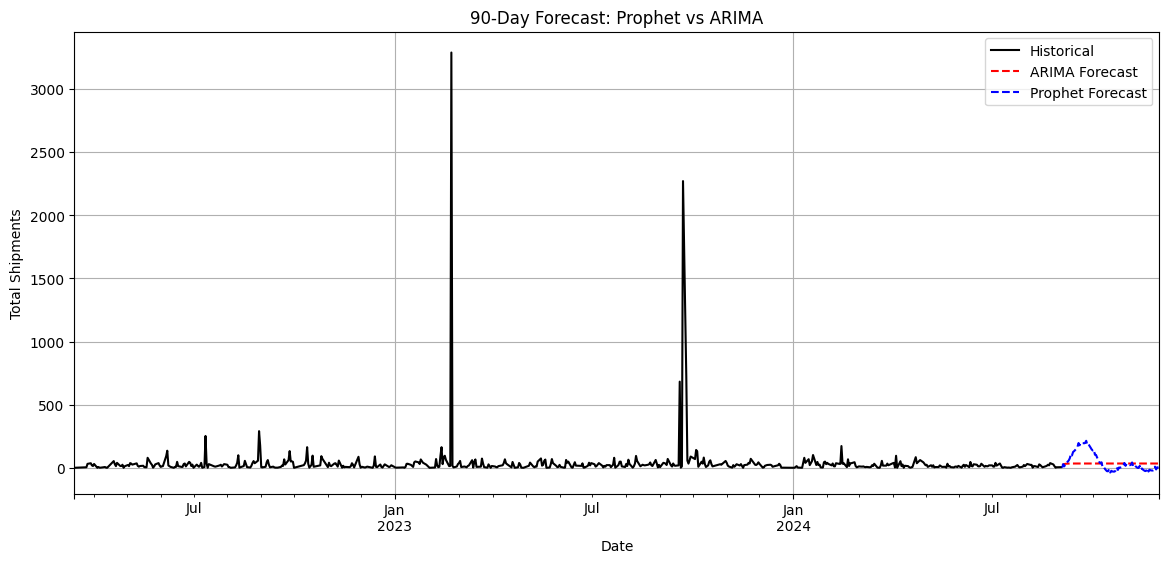

✅ Forecast saved as 'forecast_next_90_days.csv'


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from pmdarima import auto_arima

# Load and clean the data
data = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.columns = data.columns.str.strip().str.replace(" ", "_")  # Clean column names
data.set_index('Date', inplace=True)
data = data.asfreq('D')
data['Total_Shipments'].interpolate(inplace=True)

# ----------------------------------------
# PROPHET FORECAST (90 days)
# ----------------------------------------
df_prophet = data.reset_index()[['Date', 'Total_Shipments']]
df_prophet.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(df_prophet)

future_90 = prophet_model.make_future_dataframe(periods=90)
forecast_90 = prophet_model.predict(future_90)

# Extract future part only
prophet_future = forecast_90[['ds', 'yhat']].set_index('ds')[-90:]

# ----------------------------------------
# ARIMA FORECAST (90 days)
# ----------------------------------------
arima_model = auto_arima(data['Total_Shipments'], seasonal=False, trace=False)
arima_forecast = arima_model.predict(n_periods=90)
arima_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90)

# ----------------------------------------
# PLOT BOTH FORECASTS
# ----------------------------------------
plt.figure(figsize=(14,6))
data['Total_Shipments'].plot(label='Historical', color='black')
pd.Series(arima_forecast, index=arima_index).plot(label='ARIMA Forecast', linestyle='--', color='red')
prophet_future['yhat'].plot(label='Prophet Forecast', linestyle='--', color='blue')
plt.title("90-Day Forecast: Prophet vs ARIMA")
plt.xlabel("Date")
plt.ylabel("Total Shipments")
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------------------
# EXPORT FORECASTS TO CSV
# ----------------------------------------
combined = pd.DataFrame({
    'Date': arima_index,
    'ARIMA': arima_forecast,
    'Prophet': prophet_future['yhat'].values
})
combined.to_csv("forecast_next_90_days.csv", index=False)
print("✅ Forecast saved as 'forecast_next_90_days.csv'")


In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm

window_size = 90
forecast_horizon = 14
step_size = 30

rmse_results = []

# Rolling loop
for start in tqdm(range(0, len(data) - window_size - forecast_horizon, step_size)):
    train = data.iloc[start:start + window_size]
    test = data.iloc[start + window_size:start + window_size + forecast_horizon]
    
    # Prophet
    prophet_df = train.reset_index()[['Date', 'Total_Shipments']].rename(columns={'Date': 'ds', 'Total_Shipments': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=forecast_horizon)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].set_index('ds')[-forecast_horizon:]
    
    # ARIMA
    arima_model = auto_arima(train['Total_Shipments'], seasonal=False)
    arima_pred = arima_model.predict(n_periods=forecast_horizon)

    # RMSE
    actual = test['Total_Shipments'].values
    rmse_prophet = sqrt(mean_squared_error(actual, prophet_pred['yhat'].values))
    rmse_arima = sqrt(mean_squared_error(actual, arima_pred))
    
    rmse_results.append({
        'Start_Date': train.index[0],
        'End_Date': train.index[-1],
        'RMSE_Prophet': rmse_prophet,
        'RMSE_ARIMA': rmse_arima
    })

# Save RMSE comparisons
rmse_df = pd.DataFrame(rmse_results)
rmse_df.to_csv("rolling_rmse_results.csv", index=False)
print("Rolling RMSE results saved as 'rolling_rmse_results.csv'")


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]02:49:39 - cmdstanpy - INFO - Chain [1] start processing
02:49:39 - cmdstanpy - INFO - Chain [1] done processing
  4%|███                                                                                | 1/27 [00:02<01:00,  2.31s/it]02:49:41 - cmdstanpy - INFO - Chain [1] start processing
02:49:41 - cmdstanpy - INFO - Chain [1] done processing
  7%|██████▏                                                                            | 2/27 [00:06<01:28,  3.53s/it]02:49:45 - cmdstanpy - INFO - Chain [1] start processing
02:49:46 - cmdstanpy - INFO - Chain [1] done processing
 11%|█████████▏                                                                         | 3/27 [00:09<01:17,  3.25s/it]02:49:48 - cmdstanpy - INFO - Chain [1] start processing
02:49:49 - cmdstanpy - INFO - Chain [1] done processing
 15%|████████████▎                                                      

✅ Rolling RMSE results saved as 'rolling_rmse_results.csv'


In [41]:
rmse_df.to_csv("rolling_rmse_results.csv", index=False)


In [42]:
import os
print("Saved to:", os.getcwd())


Saved to: C:\Users\hp


In [43]:
print("Average RMSE Prophet:", rmse_df['RMSE_Prophet'].mean())
print("Average RMSE ARIMA:", rmse_df['RMSE_ARIMA'].mean())


Average RMSE Prophet: 53.07459449510388
Average RMSE ARIMA: 32.794507095739746


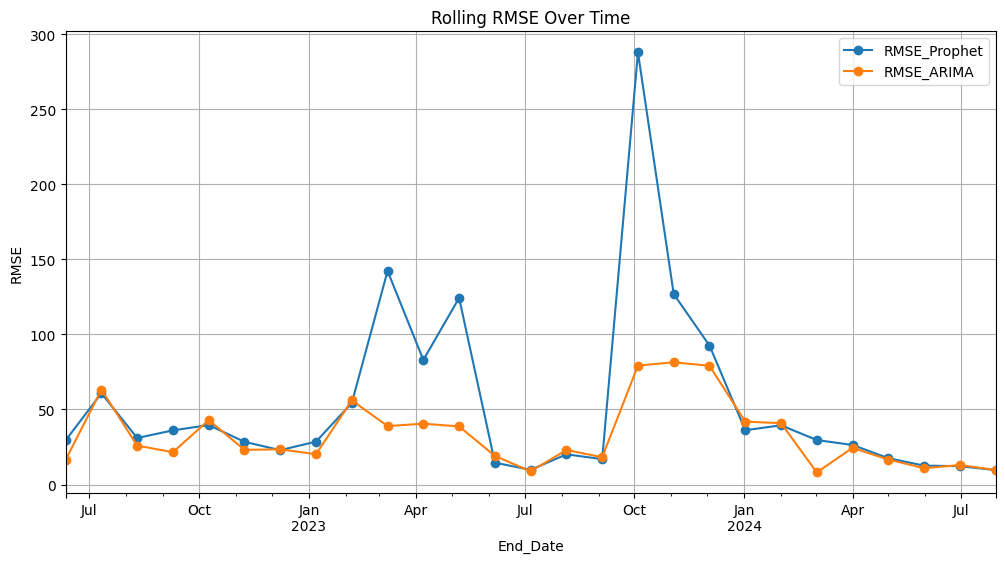

In [44]:
rmse_df.plot(x='End_Date', y=['RMSE_Prophet', 'RMSE_ARIMA'], figsize=(12,6), marker='o')
plt.title("Rolling RMSE Over Time")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()
